# 🐶End-to-end Multi-class Dog Breed CLassification

This notebook builds an end-to-end multi class image classifier using Tenserflow 2.0 and Tenserflow Hun.

## 1. Problem

Identifying the breed of a dog given an image of the dog.

When i am sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2.  Data

The data we're using is from Kaggle's dog breed identification competition.https://www.kaggle.com/c/dog-breed-identification/data

## 3.  Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4.  Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10000+ images in the training set(these images have labels)
* There are around 10000+ images in the test set(these images have no labels, because we'll want to predict them) 

In [ ]:
# Unzip the uploaded data into Google Drive
#!unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

### Get our workspace ready.
* Import TensorFlow.
* Import TensorFlow Hub.
* Make sure we're using a GPU

In [ ]:
# Import TenserFlow and necessary tools into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version", tf.__version__)
print("TF hub", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version 2.2.0
TF hub 0.8.0
GPU available (YESSS!!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models are data has to be in numerical format.So that's what we'll be doing first.Turning the images into Tensors (numerical representations)

Let's start by accessing data and checking out the labels.

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     48a96a7398a822910798b9a6c2b5e3f5  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

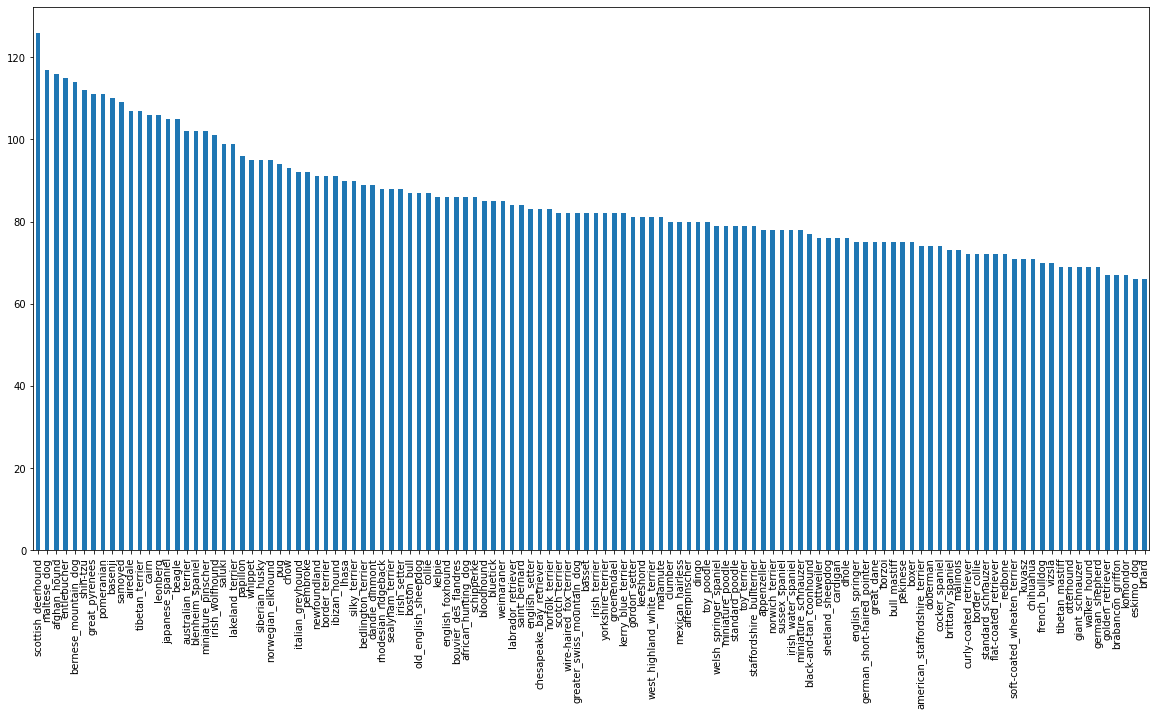

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

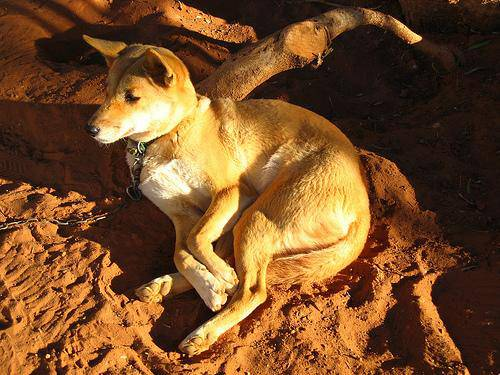

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels 
Let's get a list of all our image file pathnames.

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Vision/train/"+ fname + ".jpg" for fname in labels_csv["id"]]
# Check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual number of files!!! Proceed.")
else:
  print("Filenames do not match actual number of files, check the target directory.")

Filenames match actual number of files!!! Proceed.


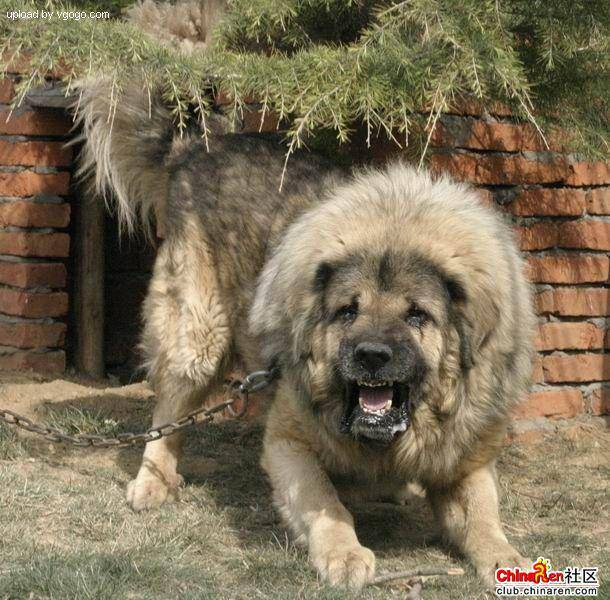

In [ ]:
# One more check
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we have got our training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # Another method to convert labels to numpy
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches number of number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check directories!")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
len(labels)

10222

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_labels[0].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:

boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set
Since the dataset from Kaggle doesnt't come with a validation set, we're going to create our own. 

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [ ]:
len(filenames)

10222

We're going to start experimenting with 1000 images and increase as needed. 

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation  of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing Images (turning images into Tensors

To preprocess  our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and serve it a variable, 'image'
3. Turn our 'image' (a jpg) into Tensors
4. Resize the to be a shape of (224, 224)
5. Return the modified 'image'

Before we do, let's see what importing an image looks like.

In [ ]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [ ]:
tf.constant(image)[:2] # Converts image to Tensors**

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and serve it a variable, 'image'
3. Turn our 'image' (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the to be a shape of (224, 224)
6. Return the modified 'image'

More information on loading images in TensorFlow can be seen here:https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor 
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colur channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is thebatch size) images at a time (you can manually adjust the batchsize if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
'(image, label)'.

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors inthe form:'(image, label)', let's make a function to turn all of our data ('X', 'y') into batches!

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to convert data into batches
def create_data_batches (X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).  
  """
  # If the data is a test dataset, we probably dont't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turning filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images 
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Creating training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Checkout the different attributes of our data batches 
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing image in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup th figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [ ]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

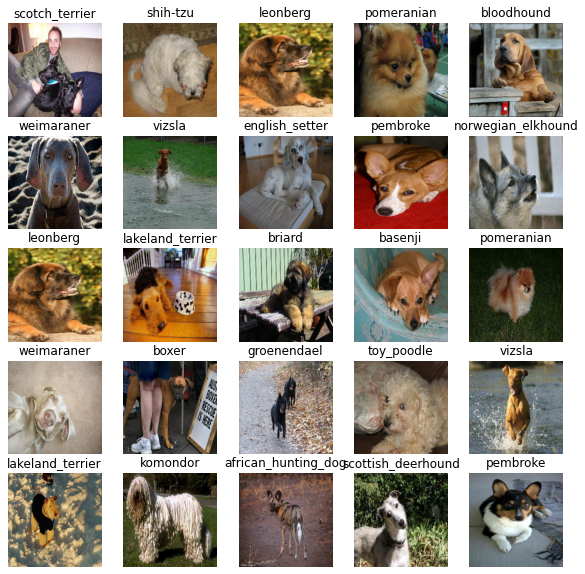

In [ ]:
# Now let's visualize the training data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

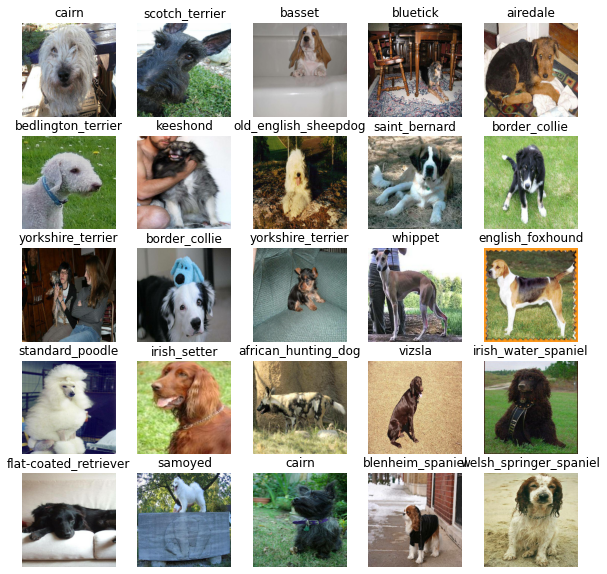

In [ ]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels) 

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub-
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4

In [ ]:
IMG_SIZE

224

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, 224, 224, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs, model ready to go.
Let's put them together into a keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, the output shape and the model we've choosen as input(parameters)
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model.
All of these can be found here:
https://www.tensorflow.org/guide/keras/overview

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stops training if a model starts improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's 'fit()' function.
3. Visualize our models training logs with the '%tensorboard' magic function(we'll do this after model training).

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                   patience=3)

## Training a model (on subset of data)

Our first model is going to train on 1000 images, to make sure everything is working.

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we are still running on a GPU
print("GPU", "available (YESSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available:(")

GPU available (YESSS!!!!!)


Let's create a function which trains a model.

* Create a model using 'create_model()'
* Setup a TensorBoard callback using 'create_tensorboard_callback()'
* Call the 'fit()' function on our model passing it the training data, validation data, numberof epochs to train for ('NUM_EPOCHS') and the callbacks we'd like to use.
* Return the model 


In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns a trained version.
  """
  # Create a model
  model = create_model()
  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 488s 20s/step - loss: 4.5805 - accuracy: 0.0988 - val_loss: 3.3758 - val_accuracy: 0.2650
Epoch 2/100
25/25 [==============================] - 6s 252ms/step - loss: 1.6273 - accuracy: 0.7075 - val_loss: 2.1047 - val_accuracy: 0.5050
Epoch 3/100
25/25 [==============================] - 6s 253ms/step - loss: 0.5728 - accuracy: 0.9312 - val_loss: 1.6059 - val_accuracy: 0.6250
Epoch 4/100
25/25 [==============================] - 6s 254ms/step - loss: 0.2554 - accuracy: 0.9850 - val_loss: 1.4232 - val_accuracy: 0.6700
Epoch 5/100
25/25 [==============================] - 6s 252ms/step - loss: 0.1491 - accuracy: 0.9975 - val_loss: 1.3481 - val_accuracy: 0.6700
Epoch 6/100
25/25 [==============================] - 6s 254ms/step - loss: 0.1016 - accuracy: 0.9987 - val_loss: 1.3019 - val_accuracy: 0.6750
Epoch 7/100
25/25 [==============================

### Checking TensorBoard logs

The TensorBoard magic function ('%tensorboard') will access the logs directory we created earlier and visualize its contents.

In [ ]:
%tensorboard --logdir drive/My\ Drive/Data/logs

<IPython.core.display.Javascript object>

## Making and evaluating predictions on a trained model

In [ ]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions 

7/7 [==============================] - 1s 162ms/step


array([[1.3522836e-03, 7.5401954e-04, 2.7746594e-04, ..., 9.9623787e-05,
        3.0574985e-05, 6.9871644e-04],
       [8.9982878e-03, 1.3292457e-04, 1.1718954e-02, ..., 1.1780474e-03,
        6.9459149e-04, 8.4749838e-05],
       [7.4110016e-05, 5.4020718e-05, 1.6262314e-04, ..., 2.0906194e-04,
        9.3713956e-05, 8.2677399e-04],
       ...,
       [4.2931783e-06, 7.4500233e-05, 2.0296642e-04, ..., 2.9280016e-05,
        3.2654800e-04, 8.9473804e-05],
       [2.0441271e-03, 1.3284666e-04, 4.0651485e-05, ..., 5.0321501e-05,
        2.9504805e-05, 5.2132574e-03],
       [1.0818993e-04, 5.2192199e-06, 5.8730034e-04, ..., 3.6892749e-03,
        3.7241046e-04, 3.5352263e-04]], dtype=float32)

In [ ]:
predictions.shape

(200, 120)

In [ ]:
len(y_val)

200

In [ ]:
len(unique_breeds)

120

In [ ]:
predictions[0]

array([1.35228364e-03, 7.54019537e-04, 2.77465937e-04, 7.56686932e-05,
       1.52040302e-04, 1.26787345e-04, 1.07260630e-01, 3.03840177e-04,
       6.66777996e-05, 1.71285809e-03, 8.44590686e-05, 1.31665904e-04,
       1.04898856e-04, 1.92027102e-04, 5.10502177e-05, 4.71733692e-05,
       1.10773879e-04, 2.23091394e-01, 5.75836339e-06, 7.18996853e-06,
       2.85625836e-04, 4.44269463e-05, 1.60271084e-05, 1.21276022e-03,
       1.49950320e-05, 3.66084656e-04, 2.82844186e-01, 4.65843987e-05,
       4.88750287e-04, 3.24407389e-04, 3.40072656e-05, 1.03599811e-03,
       7.39211973e-05, 3.44030159e-05, 5.40993860e-05, 1.37406681e-02,
       3.16481783e-05, 3.69488436e-04, 1.38036543e-04, 1.37525334e-04,
       7.50226609e-05, 1.87990518e-05, 5.82668872e-05, 6.07345486e-04,
       6.36590903e-06, 5.54065664e-05, 1.16586809e-04, 1.68161321e-04,
       4.20100929e-04, 1.04862193e-04, 1.51825210e-04, 2.92002442e-05,
       2.90131546e-04, 4.29959764e-05, 7.08347943e-05, 3.35384175e-05,
      

In [ ]:
# First prediction
index=42
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted labels: {unique_breeds[np.argmax(predictions[index])]}")

[1.35228364e-03 7.54019537e-04 2.77465937e-04 7.56686932e-05
 1.52040302e-04 1.26787345e-04 1.07260630e-01 3.03840177e-04
 6.66777996e-05 1.71285809e-03 8.44590686e-05 1.31665904e-04
 1.04898856e-04 1.92027102e-04 5.10502177e-05 4.71733692e-05
 1.10773879e-04 2.23091394e-01 5.75836339e-06 7.18996853e-06
 2.85625836e-04 4.44269463e-05 1.60271084e-05 1.21276022e-03
 1.49950320e-05 3.66084656e-04 2.82844186e-01 4.65843987e-05
 4.88750287e-04 3.24407389e-04 3.40072656e-05 1.03599811e-03
 7.39211973e-05 3.44030159e-05 5.40993860e-05 1.37406681e-02
 3.16481783e-05 3.69488436e-04 1.38036543e-04 1.37525334e-04
 7.50226609e-05 1.87990518e-05 5.82668872e-05 6.07345486e-04
 6.36590903e-06 5.54065664e-05 1.16586809e-04 1.68161321e-04
 4.20100929e-04 1.04862193e-04 1.51825210e-04 2.92002442e-05
 2.90131546e-04 4.29959764e-05 7.08347943e-05 3.35384175e-05
 1.15436451e-04 5.34650288e-04 4.24824189e-04 7.27856010e-02
 4.85268101e-04 2.01664196e-04 1.99283310e-03 5.06567667e-05
 5.37837914e-04 1.399446

In [ ]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
unique_breeds[113]

'walker_hound'

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note!** Prediction probabilities are also known as confidence levels. 

In [ ]:
# Turn prediction probabilities into their respective labels (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

Since our validation data is still in a batch dataset we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [ ]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Predicted labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visual.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

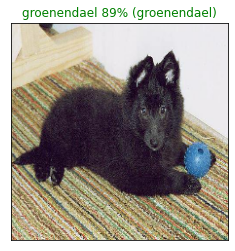

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now've got one function to visualize our models predictions, let's make another to view our models top 10 predictions

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using 'get_pred_label()'
* Find the top 10:
   * Prediction probabilities indexes
   * Prediction probabilities values
   * Prediction labels
   * Plot the top 10 prediction probability values and labels, coloring the true label green 

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels 
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass


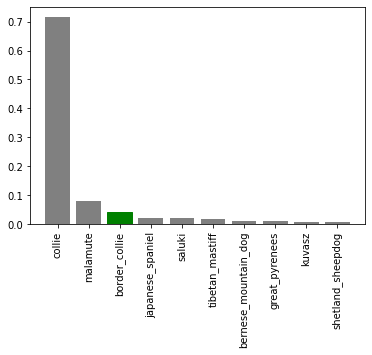

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some function to visualize our predictions and evaluate our model,let's check out a few

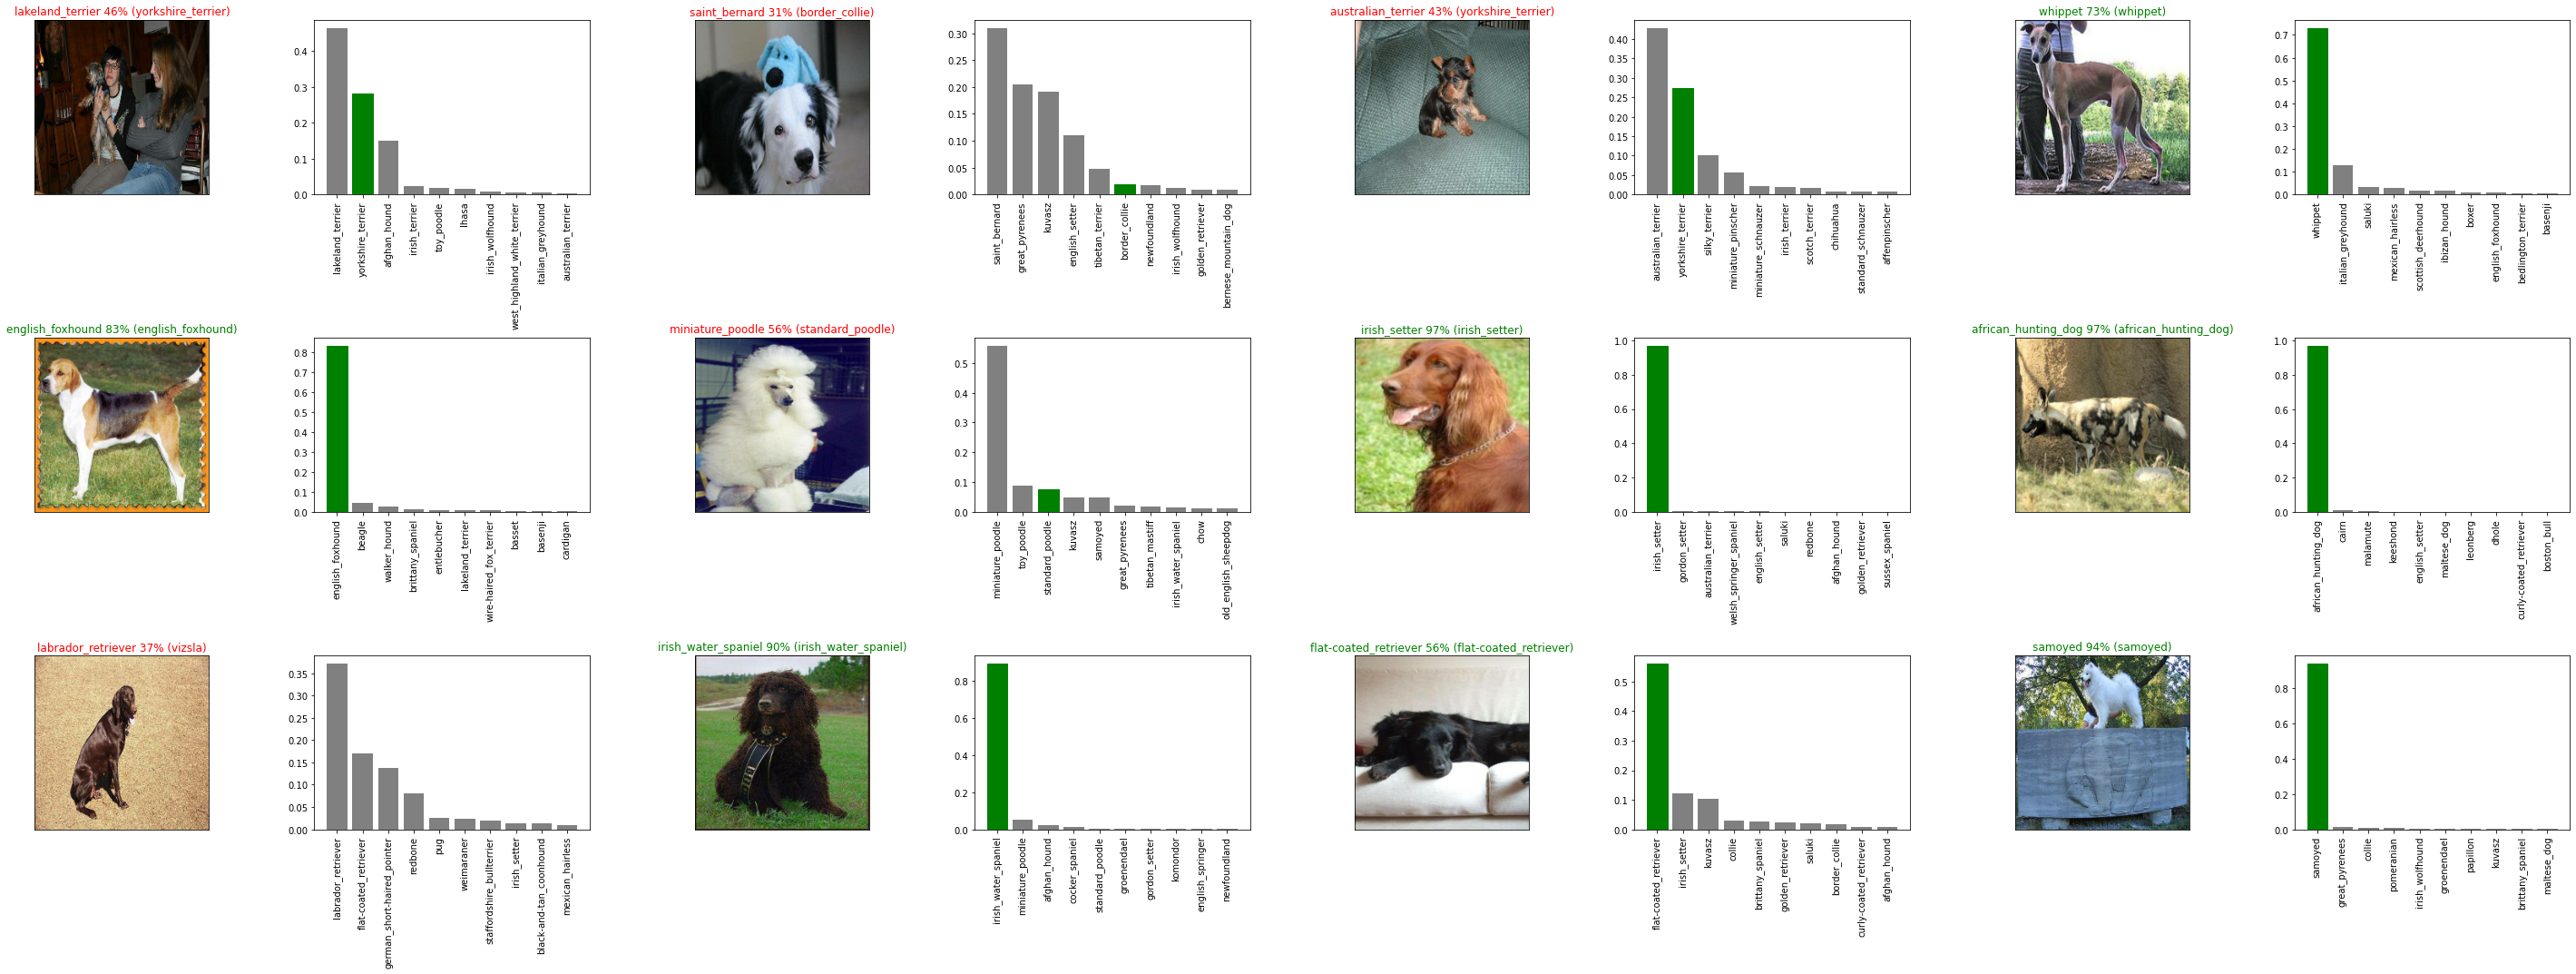

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 10
num_rows = 3
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()


**Challenge:** How would you create a confusion matrix with our models predictions and true labels? 

## Saving and reloading a trained model

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've have got functions to save and load a trained model,
let's make sure they work! 

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200604-12531591275227-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200604-12531591275227-1000-images-mobilenetv2-Adam.h5'

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model('drive/My Drive/Dog Vision/models/20200603-16561591203382-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20200603-16561591203382-1000-images-mobilenetv2-Adam.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 149ms/step - loss: 1.1859 - accuracy: 0.7100


[1.1859334707260132, 0.7099999785423279]

In [ ]:
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 156ms/step - loss: 1.2279 - accuracy: 0.6700


[1.227870225906372, 0.6700000166893005]

## Training a big dog model (on the full data)

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while (maybe upto 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory. 

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 7740s 24s/step - loss: 1.3411 - accuracy: 0.6734
Epoch 2/100
320/320 [==============================] - 67s 208ms/step - loss: 0.4017 - accuracy: 0.8808
Epoch 3/100
320/320 [==============================] - 66s 205ms/step - loss: 0.2387 - accuracy: 0.9333
Epoch 4/100
320/320 [==============================] - 68s 212ms/step - loss: 0.1550 - accuracy: 0.9627
Epoch 5/100
320/320 [==============================] - 66s 206ms/step - loss: 0.1062 - accuracy: 0.9785
Epoch 6/100
320/320 [==============================] - 66s 206ms/step - loss: 0.0797 - accuracy: 0.9853
Epoch 7/100
320/320 [==============================] - 66s 205ms/step - loss: 0.0578 - accuracy: 0.9911
Epoch 8/100
320/320 [==============================] - 66s 206ms/step - loss: 0.0455 - accuracy: 0.9952
Epoch 9/100
320/320 [==============================] - 66s 207ms/step - loss: 0.0383 - accuracy: 0.9951
Epoch 10/100
320/320 [==============================] - 67s 210m

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200604-16031591286630-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200604-16031591286630-full-image-set-mobilenetv2-Adam.h5'

In [ ]:
# Load in the full model
loaded_full_model = load_model('drive/My Drive/Dog Vision/models/20200604-16031591286630-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20200604-16031591286630-full-image-set-mobilenetv2-Adam.h5


In [ ]:
len(X)

10222

## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created 'create_data_batches()' which can take a listof filenames as input and convert them into Tensor batches.

To make predictions on test data, we'll
* Get the test image filenames
* Convert the filenames into test data batches using 'create_data_batches()' and setting the 'test_data' parameter to 'True' (since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the 'predict()' method called on our model.

In [ ]:
# Load test image filenames
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/ed574861296d0946948a4225e60e8d75.jpg',
 'drive/My Drive/Dog Vision/test/f16eed64196d24c423f0a68d7ebf287d.jpg',
 'drive/My Drive/Dog Vision/test/e92455b9e6291d0f192f23ccd4e0be3a.jpg',
 'drive/My Drive/Dog Vision/test/f4fa65b062607d69c98f16cb625d5915.jpg',
 'drive/My Drive/Dog Vision/test/f1fdf296d0252b3dfb46f1bfc37bcb63.jpg',
 'drive/My Drive/Dog Vision/test/f310b89d1a4706733a71054a26e7fb06.jpg',
 'drive/My Drive/Dog Vision/test/f14ba73b3323b3c7cfc3ba359a6c4313.jpg',
 'drive/My Drive/Dog Vision/test/ef5c93599bcc330fd9642266d9650309.jpg',
 'drive/My Drive/Dog Vision/test/f53c0a1ab2af3549a2ef5825d023b160.jpg',
 'drive/My Drive/Dog Vision/test/f398e8ff747bfbb95f4aa7660608fc4f.jpg']

In [ ]:
len(test_filenames)

10357

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling 'predict()' on our full model and passing it the test data batch will take a long time to run (about 1 hour).

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 7066s 22s/step


In [ ]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("drive/My Drive/Dog Vision/preds_array", test_predictions, delimiter=",")

In [ ]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/preds_array", delimiter=",") 

In [ ]:
test_predictions[:10]

array([[8.75910722e-09, 9.56233964e-12, 4.75408046e-11, ...,
        3.97270927e-09, 9.16087692e-12, 1.67917555e-10],
       [2.80185787e-13, 7.89683336e-12, 6.79634196e-11, ...,
        4.45181847e-09, 1.34624386e-07, 1.27761426e-10],
       [5.61712482e-12, 1.64077019e-09, 4.38181089e-12, ...,
        9.45368797e-14, 5.78202173e-14, 2.36926589e-09],
       ...,
       [1.04473930e-11, 1.46456302e-11, 5.02353931e-12, ...,
        2.07335571e-09, 1.02659943e-08, 9.28733739e-12],
       [2.17986351e-10, 2.73298800e-10, 5.65519542e-09, ...,
        2.73246746e-06, 4.26733720e-07, 2.34433377e-13],
       [8.11288758e-10, 3.92403223e-07, 1.67576317e-11, ...,
        2.02782138e-10, 7.25706049e-14, 1.42095441e-11]])

In [ ]:
test_predictions.shape

(10357, 120)

## Preparing test data predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed
* Add data to the ID column by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
# ["id"] + list(unique_breeds)

In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [ ]:
test_filenames

['drive/My Drive/Dog Vision/test/ed574861296d0946948a4225e60e8d75.jpg',
 'drive/My Drive/Dog Vision/test/f16eed64196d24c423f0a68d7ebf287d.jpg',
 'drive/My Drive/Dog Vision/test/e92455b9e6291d0f192f23ccd4e0be3a.jpg',
 'drive/My Drive/Dog Vision/test/f4fa65b062607d69c98f16cb625d5915.jpg',
 'drive/My Drive/Dog Vision/test/f1fdf296d0252b3dfb46f1bfc37bcb63.jpg',
 'drive/My Drive/Dog Vision/test/f310b89d1a4706733a71054a26e7fb06.jpg',
 'drive/My Drive/Dog Vision/test/f14ba73b3323b3c7cfc3ba359a6c4313.jpg',
 'drive/My Drive/Dog Vision/test/ef5c93599bcc330fd9642266d9650309.jpg',
 'drive/My Drive/Dog Vision/test/f53c0a1ab2af3549a2ef5825d023b160.jpg',
 'drive/My Drive/Dog Vision/test/f398e8ff747bfbb95f4aa7660608fc4f.jpg',
 'drive/My Drive/Dog Vision/test/e9d385cf5f217ce1378bee8c0a89db62.jpg',
 'drive/My Drive/Dog Vision/test/f47e4614a5d7d190cf95b4b9c1e78576.jpg',
 'drive/My Drive/Dog Vision/test/f07d1123c4259713a46991de0b02ffd0.jpg',
 'drive/My Drive/Dog Vision/test/f3482b871bff6a7d6907f10eeac75ae

In [ ]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

id  ... yorkshire_terrier
0  ed574861296d0946948a4225e60e8d75  ...               NaN
1  f16eed64196d24c423f0a68d7ebf287d  ...               NaN
2  e92455b9e6291d0f192f23ccd4e0be3a  ...               NaN
3  f4fa65b062607d69c98f16cb625d5915  ...               NaN
4  f1fdf296d0252b3dfb46f1bfc37bcb63  ...               NaN

[5 rows x 121 columns]

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  ed574861296d0946948a4225e60e8d75  ...       1.67918e-10
1  f16eed64196d24c423f0a68d7ebf287d  ...       1.27761e-10
2  e92455b9e6291d0f192f23ccd4e0be3a  ...       2.36927e-09
3  f4fa65b062607d69c98f16cb625d5915  ...       7.21104e-13
4  f1fdf296d0252b3dfb46f1bfc37bcb63  ...       7.17397e-12

[5 rows x 121 columns]

In [ ]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using 'create_data_batches()'.And since our custom images won't have labels, we set the 'test_data' parameter to true.
* Pass the custom image data batch to our model's 'predict()' method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images

In [ ]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog Vision/my-dog-photos"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

['drive/My Drive/Dog Vision/my-dog-photos.ipynb_checkpoints',
 'drive/My Drive/Dog Vision/my-dog-photosdog-photo.png']

In [ ]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>